In [1]:
# Given a +- score what is the probability of winning the game?

In [3]:
!scp -r boltio.schrodinger.com:/nfs/working/deep_learn/leswing/madness/models/16 ./

reg_model.pt                                  100%  298KB   2.4MB/s   00:00    
model_checkpoint.pt                           100%  891KB   3.9MB/s   00:00    
reg_model.pt                                  100%  298KB   3.8MB/s   00:00    
model_checkpoint.pt                           100%  891KB   4.7MB/s   00:00    
reg_model.pt                                  100%  298KB   2.7MB/s   00:00    
model_checkpoint.pt                           100%  891KB   5.8MB/s   00:00    
reg_model.pt                                  100%  298KB   6.3MB/s   00:00    
model_checkpoint.pt                           100%  891KB   6.9MB/s   00:00    
reg_model.pt                                  100%  298KB   6.3MB/s   00:00    
model_checkpoint.pt                           100%  891KB   7.1MB/s   00:00    
reg_model.pt                                  100%  298KB   6.2MB/s   00:00    
model_checkpoint.pt                           100%  891KB   7.7MB/s   00:00    
reg_model.pt                            

In [4]:
!mv 16 models

In [1]:
import hashlib
import os
import numpy as np
import pickle
import json

from ligand_ml.data import NumpyDataset
from ligand_ml.data import DiskDataset
from ligand_ml.models.torchm.model_mechanics import DenseModel


def load_transformers():
    with open('transformers.pkl', 'rb') as fin:
        return pickle.load(fin)


def get_team_fvs(year):
    d = json.loads(open('team_fvs.json').read())

    X = []
    team_names = []
    for k, v in d.items():
        if k.find(year) == -1:
            continue
        X.append(v[0])
        team_names.append(k)

    print(len(team_names))
    ds = NumpyDataset(X, np.ones(len(X)), np.ones(len(X)), range(len(X)))

    return ds.X, team_names


def create_dataset(year):
    fvs, team_names = get_team_fvs(year)
    X = []
    for i, t1 in enumerate(team_names):
        for j, t2 in enumerate(team_names):
            if j <= i:
                continue
            fv1 = np.concatenate([fvs[i], fvs[j]])
            fv2 = np.concatenate([fvs[j], fvs[i]])
            X.append(fv1)
            X.append(fv2)
    print(np.array(X).shape)
    ds = NumpyDataset(X, np.ones(len(X)), np.ones(len(X)), range(len(X)))
    transformers = load_transformers()
    for trans in transformers:
        ds = trans.transform(ds)
    return ds


def make_predictions(ds, model_key):
    transformers = load_transformers()
    all_preds = []
    for fold in range(5):
        path = os.path.join('models', model_key, str(fold))
        d = DenseModel(path, mode='regression')
        preds = np.squeeze(d.predict(ds))
        preds = transformers[1].untransform(preds)
        all_preds.append(preds)

    retval = np.mean(all_preds, axis=0)
    print(f"Predictions shape {retval.shape}")
    return retval


def convert_to_games(predictions, year):
    fvs, team_names = get_team_fvs(year)
    games = []
    for i, t1 in enumerate(team_names):
        for j, t2 in enumerate(team_names):
            if j <= i:
                continue
            games.append((t1, t2))

    results = {}
    index = 0
    while index < len(predictions):
        v1, v2 = predictions[index], predictions[index + 1]
        v2 *= -1
        average = (v1 + v2) / 2

        t1, t2 = games[index // 2]
        results[f"{t1}:{t2}"] = average
        results[f"{t2}:{t1}"] = average * -1
        index += 2
    return results


def play_year(year):
    with open('models/best_params.json', 'r') as fin:
        best_params = json.loads(fin.read())
    model_key = hashlib.md5(str(best_params).encode('utf-8')).hexdigest()

    ds = create_dataset(year)
    predictions = make_predictions(ds, model_key)
    predictions = convert_to_games(predictions, year)
    with open(f'results_{year}.json', 'w') as fout:
        fout.write(json.dumps(predictions, indent=4, sort_keys=True))


/Users/leswing/miniconda3/envs/ligand_ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leswing/miniconda3/envs/ligand_ml/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [2]:
with open('models/best_params.json', 'r') as fin:
    best_params = json.loads(fin.read())
model_key = hashlib.md5(str(best_params).encode('utf-8')).hexdigest()

ds = DiskDataset('datasets/full_folds/valid0')

preds = make_predictions(ds, model_key) - load_transformers()[1].y_means

Predictions shape (14358,)


(array([3.111e+03, 2.257e+03, 1.061e+03, 4.480e+02, 1.990e+02, 7.500e+01,
        2.000e+01, 4.000e+00, 3.000e+00, 1.000e+00]),
 array([-1.18861755, -0.33351872,  0.52158012,  1.37667896,  2.23177779,
         3.08687663,  3.94197546,  4.7970743 ,  5.65217313,  6.50727197,
         7.36237081]),
 <BarContainer object of 10 artists>)

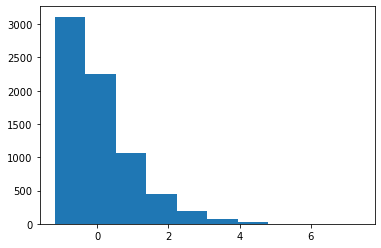

In [6]:
plt.hist(ds.y[:num_games])

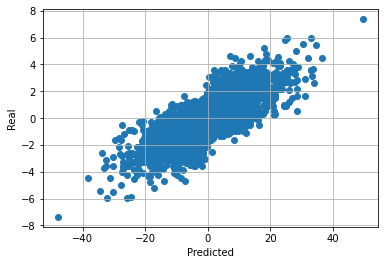

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.grid()
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.scatter(preds, ds.y)

In [5]:
num_games = ds.X.shape[0]//2
first_games = ds.X[:num_games,:]
second_games = ds.X[num_games:,:]

In [21]:
first_games[0][39:]

array([ 0.39051817,  0.14927447,  1.99504397, -1.51669343, -0.93992711,
       -0.2222414 ,  1.07106879, -0.26541186,  0.82641669, -0.40656357,
        1.55342018,  0.51530337,  1.09324626,  1.09324626,  1.56888857,
        1.56888857,  0.52800416,  0.52800416, -0.27063402, -0.27063402,
        2.14556601,  2.14556601,  0.09863349,  0.09863349, -0.8343968 ,
       -0.8343968 ,  0.69833552,  0.69833552,  0.42690812, -0.54595687,
       -0.88688298,  0.04907085,  0.68615829,  0.67411224,  1.4380163 ,
       -0.84279399, -2.04588278,  0.16607494, -0.96463887])

In [131]:
avg_results = []
for i in range(num_games):
    v = (preds[i] + preds[i+num_games]*-1) / 2
    avg_results.append(v)

In [132]:
avg_results

[1.6739649673961043,
 1.8093799942843463,
 21.834093792794622,
 -1.9887219162054786,
 -0.701419605539293,
 -1.0265000432799907,
 0.09450973335331803,
 2.743015645413016,
 -2.7697829737525828,
 2.4963570544804217,
 10.266502737861352,
 20.837284085667356,
 0.4322559906982031,
 3.8385585390984724,
 -2.629227046092831,
 0.03384085471199594,
 1.4659580091318496,
 -1.5636336989336819,
 3.703648355517007,
 7.596841743852456,
 -1.7950869143610868,
 -3.709739818225608,
 6.768472475151686,
 14.328557867952672,
 -1.7950869143610868,
 4.110312320007787,
 5.129024692804554,
 -0.18144290434134103,
 5.332529908734394,
 -0.12052913638551743,
 10.737743954980612,
 17.79868868987367,
 0.7912163669058261,
 1.825467414696588,
 5.961929315318313,
 3.2744556969412173,
 0.4623701649800056,
 -2.231345314221806,
 -0.7868371261239844,
 -5.740199065000408,
 4.130731510064871,
 14.628877385760129,
 1.8197255822637857,
 1.992402201024687,
 15.195291442116925,
 0.06331835717285106,
 -1.5956236318841501,
 -3.031325

In [116]:
np.all(ds.y[:num_games] > 0)

True

In [29]:
transformers = load_transformers()

In [35]:
points_preds = transformers[1].untransform(preds)
points_real = transformers[1].untransform(ds.y)

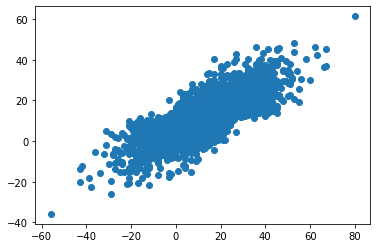

In [36]:
plt.scatter(points_real, points_preds)

(array([3.000e+00, 1.200e+01, 9.900e+01, 5.560e+02, 6.509e+03, 6.509e+03,
        5.560e+02, 9.900e+01, 1.200e+01, 3.000e+00]),
 array([-56.03744254, -42.43369829, -28.82995403, -15.22620978,
         -1.62246552,  11.98127873,  25.58502298,  39.18876724,
         52.79251149,  66.39625575,  80.        ]),
 <BarContainer object of 10 artists>)

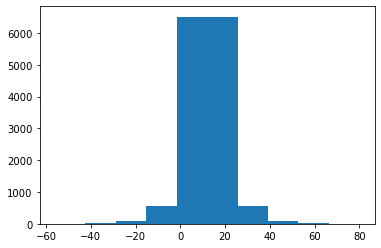

In [37]:
plt.hist(points_real)

In [39]:
transformers[1].y_means

array([11.98127873])

In [40]:
ds = DiskDataset('datasets/combined')

In [92]:
X = ds.X
n_features = X.shape[1] // 2
t1 = X[:, :n_features]

win_loss_x = np.concatenate([t1, t1], axis=1)
win_loss_x = np.concatenate([win_loss_x, win_loss_x], axis=0)
win_loss_y = np.concatenate([ds.y, ds.y * -1], axis=0)
win_loss_ds = NumpyDataset(win_loss_x, win_loss_y)

(array([2.0000e+00, 3.8000e+01, 6.4700e+02, 6.4160e+03, 2.8792e+04,
        2.8792e+04, 6.4160e+03, 6.4700e+02, 3.8000e+01, 2.0000e+00]),
 array([-94. , -75.2, -56.4, -37.6, -18.8,   0. ,  18.8,  37.6,  56.4,
         75.2,  94. ]),
 <BarContainer object of 10 artists>)

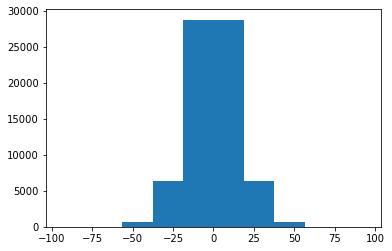

In [93]:
plt.hist(win_loss_ds.y)

In [94]:
from ligand_ml.trans.transformers import NormalizationTransformer
transformers1 = [
        NormalizationTransformer(transform_X=True, dataset=win_loss_ds),
        NormalizationTransformer(transform_y=True, dataset=win_loss_ds)
]

In [97]:
transformers = load_transformers()
transformers[1].y_means

array([-1.81722991e-14])

In [95]:
NormalizationTransformer(transform_y=True, dataset=win_loss_ds).y_means

array([-1.81722991e-14])

In [96]:
NormalizationTransformer(transform_y=True, dataset=win_loss_ds).y_stds

array([15.12959295])

In [91]:
len(ds), len(win_loss_ds), len(ds) * 2

(35895, 71790, 71790)

In [87]:
win_loss_ds.get_statistics(y_stats=True, X_stats=False)

(array([11.98127873]), array([9.23869811]))

In [81]:
win_loss_ds.get_statistics()

(array([1.06252417e+02, 1.01758420e+02, 6.79024600e+01, 1.73907257e+01,
        1.74676557e+01, 5.09529210e+01, 4.95457780e+01, 1.82161861e+01,
        1.86578326e+01, 2.90843460e+01, 2.81916228e+01, 3.36541134e+01,
        3.28745480e+01, 3.28745480e+01, 3.38225602e+01, 3.38225602e+01,
        4.88604207e+01, 4.88604207e+01, 7.07636607e+01, 7.07636607e+01,
        9.45863212e+00, 9.45863212e+00, 9.04073269e+00, 9.04073269e+00,
        3.71597409e+01, 3.71597409e+01, 5.12231146e+01, 5.12231146e+01,
        3.08068700e+01, 3.08474969e+01, 5.01928402e+01, 5.02153058e+01,
        1.90002117e+01, 1.89362780e+01, 1.04491453e+02, 1.03346304e+02,
        1.64224655e+00, 7.69500404e+01, 2.01892250e+03, 1.06252417e+02,
        1.01758420e+02, 6.79024600e+01, 1.73907257e+01, 1.74676557e+01,
        5.09529210e+01, 4.95457780e+01, 1.82161861e+01, 1.86578326e+01,
        2.90843460e+01, 2.81916228e+01, 3.36541134e+01, 3.28745480e+01,
        3.28745480e+01, 3.38225602e+01, 3.38225602e+01, 4.886042

In [50]:
t_ds = transformers[1].transform(win_loss_ds)

(array([2.0000e+00, 3.8000e+01, 6.4700e+02, 6.4160e+03, 2.8792e+04,
        2.8792e+04, 6.4160e+03, 6.4700e+02, 3.8000e+01, 2.0000e+00]),
 array([-11.47145165,  -9.4365329 ,  -7.40161416,  -5.36669541,
         -3.33177666,  -1.29685791,   0.73806084,   2.77297959,
          4.80789833,   6.84281708,   8.87773583]),
 <BarContainer object of 10 artists>)

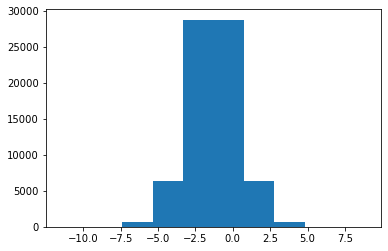

In [51]:
plt.hist(t_ds.y)

In [54]:
win_loss_ds.y.shape

(71790, 1)

In [56]:
win_loss_ds.get_statistics(X_stats=False, y_stats=True)

(array([11.98127873]), array([9.23869811]))

In [71]:
np.mean(win_loss_ds.y)

0.0

In [59]:
np.std(win_loss_ds.y)

15.129592949282424

In [61]:
transformers[1].y_means

array([11.98127873])

In [62]:
transformers[1].y_stds

array([9.23869811])

In [68]:
np.isclose(transformers[0].X_means, np.mean(ds.X, axis=0))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True])

In [72]:
np.mean(ds.y)

11.981278729628082